# PyTorch Basics Notebook
### Introduction to Tensors, Datasets, DataLoaders, CNNs, and U‑Net Building Blocks

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Required Libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt


## PyTorch Tensors

In [4]:
# Creating tensors
x = torch.tensor([1.0, 2.0, 3.0])
y = torch.randn(3)  # random tensor

print(x)
print(y)

# Tensor operations
print('Addition:', x + y)
print('Mean:', x.mean())


tensor([1., 2., 3.])
tensor([0.1545, 0.6143, 0.2130])
Addition: tensor([1.1545, 2.6143, 3.2130])
Mean: tensor(2.)


## Autograd Basics

In [5]:
# Enable gradient tracking
a = torch.tensor([2.0, 3.0], requires_grad=True)
b = (a * a).sum()
b.backward()
print(a.grad)  # derivative of x^2 is 2x


tensor([4., 6.])


## Custom PyTorch Dataset

We simulate MRI-like slices using random arrays just for practice.

In [6]:
class RandomMRIDataset(Dataset):
    def __init__(self, length=100):
        self.length = length

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        image = torch.randn(1, 64, 64)      # fake MRI slice
        mask = (torch.randn(1, 64, 64) > 0).float()  # fake mask
        return image, mask

dataset = RandomMRIDataset()
img, msk = dataset[0]
img.shape, msk.shape


(torch.Size([1, 64, 64]), torch.Size([1, 64, 64]))

## DataLoader

In [7]:
loader = DataLoader(dataset, batch_size=8, shuffle=True)

for images, masks in loader:
    print(images.shape, masks.shape)
    break


torch.Size([8, 1, 64, 64]) torch.Size([8, 1, 64, 64])


## Building a Simple CNN

In [8]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 16 * 16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        return self.classifier(x)

model = SimpleCNN()
print(model)


SimpleCNN(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8192, out_features=1, bias=True)
    (2): Sigmoid()
  )
)


## Training Loop Example

In [9]:
model = SimpleCNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(2):
    for images, masks in loader:
        optimizer.zero_grad()
        preds = model(images)
        loss = criterion(preds, torch.zeros_like(preds))  # dummy target
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')


Epoch 1, Loss: 0.0000
Epoch 2, Loss: 0.0000


## U‑Net Building Blocks

In [10]:
def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU()
    )

sample = torch.randn(1, 1, 128, 128)
block = conv_block(1, 16)
output = block(sample)
output.shape


torch.Size([1, 16, 128, 128])

## Exercises


1. Modify `RandomMRIDataset` to return a resized (128×128) slice using interpolation.  
2. Add another convolution layer to `SimpleCNN` and observe how the model size changes.  
3. Implement a small encoder-decoder network (mini U-Net) using `conv_block`.  
4. Write a custom Dice Loss function in PyTorch.  
5. Train the CNN on the random dataset and plot the loss curve using matplotlib.  


## Exercise 1: Modify Dataset to Return Resized (128×128) Slices

EXERCISE 1: Modified RandomMRIDataset with Resizing
Created dataset with 10 samples

Single sample shapes:
  Image: torch.Size([1, 128, 128])  (Expected: torch.Size([1, 128, 128]))
  Mask:  torch.Size([1, 128, 128])  (Expected: torch.Size([1, 128, 128]))

Batch shapes from DataLoader:
  Images: torch.Size([4, 1, 128, 128])  (Expected: torch.Size([4, 1, 128, 128]))
  Masks:  torch.Size([4, 1, 128, 128])   (Expected: torch.Size([4, 1, 128, 128]))

Visualizing resized samples...


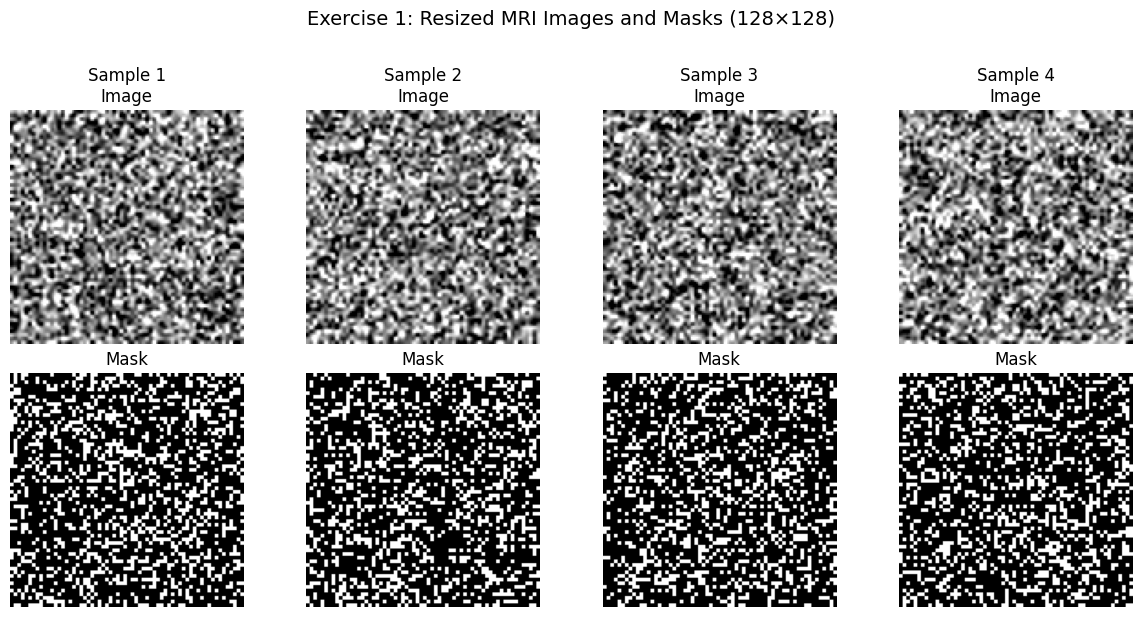


✓ EXERCISE 1 COMPLETED SUCCESSFULLY!


In [23]:
# EXERCISE 1 SOLUTION - Complete and self-contained
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

print("="*60)
print("EXERCISE 1: Modified RandomMRIDataset with Resizing")
print("="*60)

# 1. Define the modified dataset class
class RandomMRIDatasetResized(Dataset):
    def __init__(self, length=50, original_size=(64, 64), target_size=(128, 128)):
        self.length = length
        self.original_size = original_size
        self.target_size = target_size

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        # Generate random MRI-like slice
        image = torch.randn(1, *self.original_size) * 0.5 + 0.5  # Normal distribution centered at 0.5

        # Generate random binary mask (simulating tumor)
        mask = (torch.rand(1, *self.original_size) > 0.7).float()

        # Resize to target size
        # Note: unsqueeze adds batch dimension required by F.interpolate
        image_resized = F.interpolate(
            image.unsqueeze(0),  # Shape becomes (1, 1, 64, 64)
            size=self.target_size,
            mode='bilinear',      # Smooth interpolation for images
            align_corners=False
        ).squeeze(0)  # Remove batch dimension back to (1, 128, 128)

        mask_resized = F.interpolate(
            mask.unsqueeze(0),
            size=self.target_size,
            mode='nearest'        # Preserve binary values (0 or 1)
        ).squeeze(0)

        return image_resized, mask_resized

# 2. Test the dataset
dataset = RandomMRIDatasetResized(length=10, target_size=(128, 128))
print(f"Created dataset with {len(dataset)} samples")

# Get one sample
img, mask = dataset[0]
print(f"\nSingle sample shapes:")
print(f"  Image: {img.shape}  (Expected: torch.Size([1, 128, 128]))")
print(f"  Mask:  {mask.shape}  (Expected: torch.Size([1, 128, 128]))")

# 3. Test DataLoader
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)
batch_images, batch_masks = next(iter(dataloader))
print(f"\nBatch shapes from DataLoader:")
print(f"  Images: {batch_images.shape}  (Expected: torch.Size([4, 1, 128, 128]))")
print(f"  Masks:  {batch_masks.shape}   (Expected: torch.Size([4, 1, 128, 128]))")

# 4. Visualize results
print("\nVisualizing resized samples...")
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

for i in range(4):
    # Get sample
    img_sample, mask_sample = dataset[i]

    # Plot image
    axes[0, i].imshow(img_sample.squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
    axes[0, i].set_title(f'Sample {i+1}\nImage')
    axes[0, i].axis('off')

    # Plot mask
    axes[1, i].imshow(mask_sample.squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
    axes[1, i].set_title(f'Mask')
    axes[1, i].axis('off')

plt.suptitle('Exercise 1: Resized MRI Images and Masks (128×128)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("✓ EXERCISE 1 COMPLETED SUCCESSFULLY!")
print("="*60)

## Exercise 2: Add Another Convolution Layer to SimpleCNN

EXERCISE 2: Enhanced SimpleCNN with Extra Convolution Layer
Comparing model architectures...

1. ORIGINAL SimpleCNN:
SimpleCNN(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8192, out_features=1, bias=True)
    (2): Sigmoid()
  )
)

2. ENHANCED SimpleCNN (with extra layer):
EnhancedSimpleCNN(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  

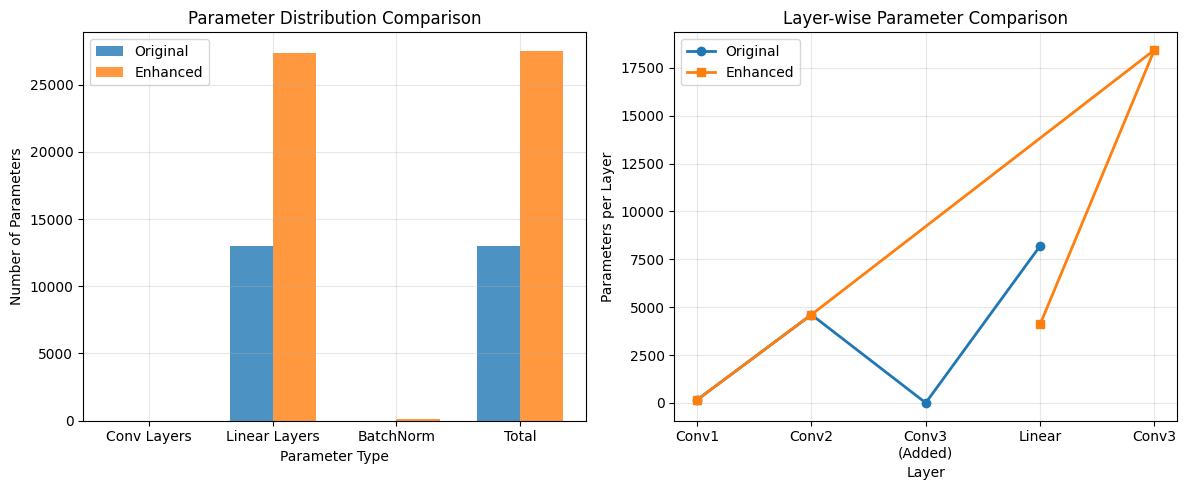


✓ EXERCISE 2 COMPLETED SUCCESSFULLY!


In [24]:
# EXERCISE 2 SOLUTION - Complete and self-contained
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

print("="*60)
print("EXERCISE 2: Enhanced SimpleCNN with Extra Convolution Layer")
print("="*60)

# 1. Original SimpleCNN (for comparison)
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        # After 2 MaxPool2d(2): 64×64 → 32×32 → 16×16
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 16 * 16, 1),  # 32×16×16 = 8192
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        return self.classifier(x)

# 2. Enhanced SimpleCNN with extra convolution layer
class EnhancedSimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            # Layer 1 (original)
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 64×64 → 32×32

            # Layer 2 (original)
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 32×32 → 16×16

            # Layer 3 (NEW - extra layer)
            nn.Conv2d(32, 64, 3, padding=1),  # Added: more channels
            nn.ReLU(),
            nn.MaxPool2d(2),  # 16×16 → 8×8

            # Optional: You can add BatchNorm for better training
            nn.BatchNorm2d(64),
        )
        # After 3 MaxPool2d(2): 64×64 → 32×32 → 16×16 → 8×8
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 1),  # 64×8×8 = 4096 (changed from 8192)
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        return self.classifier(x)

# 3. Compare the models
print("Comparing model architectures...")
print("\n1. ORIGINAL SimpleCNN:")
model_original = SimpleCNN()
print(model_original)

print("\n2. ENHANCED SimpleCNN (with extra layer):")
model_enhanced = EnhancedSimpleCNN()
print(model_enhanced)

# 4. Count parameters
def count_params(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

orig_total, orig_trainable = count_params(model_original)
enh_total, enh_trainable = count_params(model_enhanced)

print("\n" + "="*60)
print("PARAMETER COMPARISON:")
print("="*60)
print(f"Original SimpleCNN:")
print(f"  Total parameters:      {orig_total:,}")
print(f"  Trainable parameters:  {orig_trainable:,}")

print(f"\nEnhanced SimpleCNN:")
print(f"  Total parameters:      {enh_total:,}")
print(f"  Trainable parameters:  {enh_trainable:,}")

print(f"\nParameter increase: {(enh_total - orig_total):,} parameters")
print(f"Percentage increase: {((enh_total - orig_total) / orig_total * 100):.1f}%")

# 5. Test with sample input
print("\n" + "="*60)
print("TESTING WITH SAMPLE INPUT:")
print("="*60)

# Create sample input (batch of 4, 1 channel, 64×64)
sample_input = torch.randn(4, 1, 64, 64)
print(f"Input shape: {sample_input.shape}")

# Forward pass through both models
with torch.no_grad():
    output_original = model_original(sample_input)
    output_enhanced = model_enhanced(sample_input)

print(f"\nOriginal model output shape: {output_original.shape}")
print(f"Enhanced model output shape: {output_enhanced.shape}")

# 6. Visualize model architectures
print("\n" + "="*60)
print("MODEL ARCHITECTURE VISUALIZATION:")
print("="*60)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot parameter distribution
param_types = ['Conv Layers', 'Linear Layers', 'BatchNorm', 'Total']
orig_params = [orig_total - orig_trainable, orig_trainable, 0, orig_total]
enh_params = [enh_total - enh_trainable, enh_trainable - 64*2, 64*2, enh_total]

x = range(len(param_types))
width = 0.35

axes[0].bar([i - width/2 for i in x], orig_params[:3] + [orig_total], width=width, label='Original', alpha=0.8)
axes[0].bar([i + width/2 for i in x], enh_params[:3] + [enh_total], width=width, label='Enhanced', alpha=0.8)
axes[0].set_xlabel('Parameter Type')
axes[0].set_ylabel('Number of Parameters')
axes[0].set_title('Parameter Distribution Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(param_types)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot layer-wise comparison
layers = ['Conv1', 'Conv2', 'Conv3', 'Linear']
orig_layer_params = [16*10, 32*144, 0, 8192]  # Approximate
enh_layer_params = [16*10, 32*144, 64*288, 4096]

axes[1].plot(layers[:2] + ['Conv3\n(Added)'] + ['Linear'], orig_layer_params[:2] + [0] + [orig_layer_params[3]],
             marker='o', label='Original', linewidth=2)
axes[1].plot(layers, enh_layer_params, marker='s', label='Enhanced', linewidth=2)
axes[1].set_xlabel('Layer')
axes[1].set_ylabel('Parameters per Layer')
axes[1].set_title('Layer-wise Parameter Comparison')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("✓ EXERCISE 2 COMPLETED SUCCESSFULLY!")
print("="*60)

## Exercise 3: Implement Mini U-Net

EXERCISE 3: Mini U-Net Implementation
Creating Mini U-Net model...
MiniUNet(
  (enc1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bottleneck): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (upconv2): ConvTranspose2d(64, 32, kernel_size=(

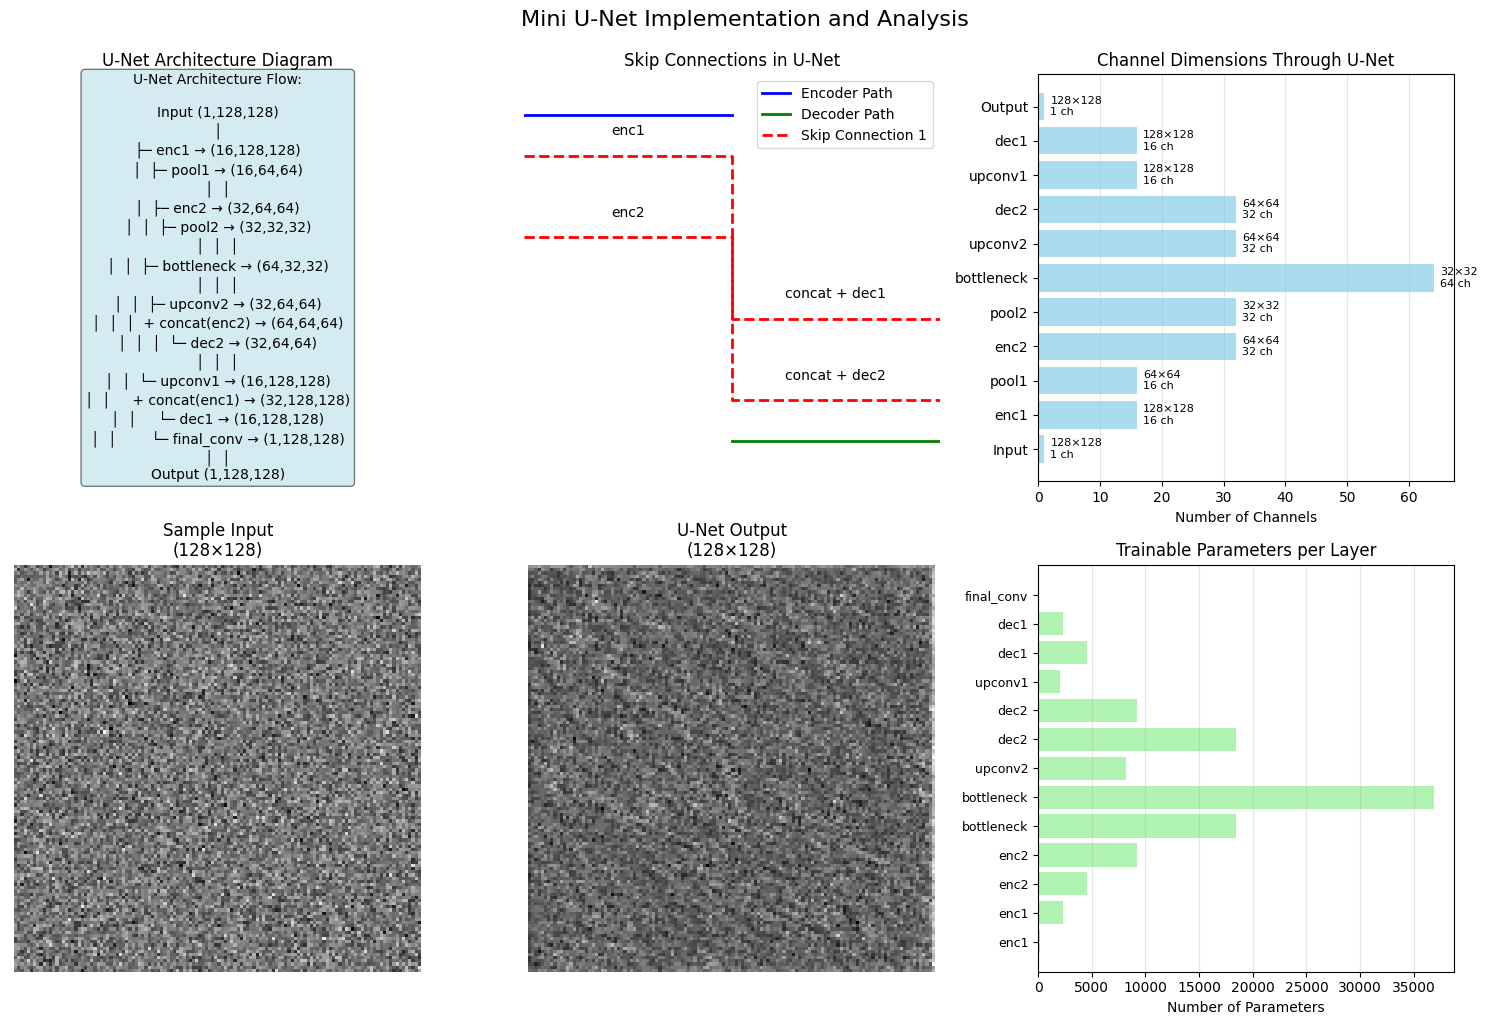


MINI U-NET SUMMARY STATISTICS:
Total parameters: 116,753
Trainable parameters: 116,753
Number of layers: 31
Input shape: (batch, 1, 128, 128)
Output shape: (batch, 1, 128, 128)

Key features:
  • Symmetric encoder-decoder architecture
  • Skip connections preserve spatial information
  • Output matches input size (important for segmentation)
  • Final sigmoid activation for binary segmentation

✓ EXERCISE 3 COMPLETED SUCCESSFULLY!


In [25]:
# EXERCISE 3 SOLUTION - Complete and self-contained
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

print("="*60)
print("EXERCISE 3: Mini U-Net Implementation")
print("="*60)

# 1. Define the conv_block function (from notebook)
def conv_block(in_channels, out_channels):
    """Double convolution block used in U-Net"""
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True)
    )

# 2. Implement Mini U-Net
class MiniUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()

        # Encoder (Contracting path)
        self.enc1 = conv_block(in_channels, 16)      # 128×128 → 128×128
        self.pool1 = nn.MaxPool2d(2)                # 128×128 → 64×64

        self.enc2 = conv_block(16, 32)              # 64×64 → 64×64
        self.pool2 = nn.MaxPool2d(2)                # 64×64 → 32×32

        # Bottleneck
        self.bottleneck = conv_block(32, 64)        # 32×32 → 32×32

        # Decoder (Expanding path)
        self.upconv2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)  # 32×32 → 64×64
        self.dec2 = conv_block(64, 32)  # 64 channels after concatenation

        self.upconv1 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)  # 64×64 → 128×128
        self.dec1 = conv_block(32, 16)  # 32 channels after concatenation

        # Final convolution
        self.final_conv = nn.Conv2d(16, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        enc1_out = self.enc1(x)          # Save for skip connection
        enc1_pooled = self.pool1(enc1_out)

        enc2_out = self.enc2(enc1_pooled)  # Save for skip connection
        enc2_pooled = self.pool2(enc2_out)

        # Bottleneck
        bottleneck_out = self.bottleneck(enc2_pooled)

        # Decoder with skip connections
        up2 = self.upconv2(bottleneck_out)
        # Concatenate with enc2_out (skip connection)
        cat2 = torch.cat([up2, enc2_out], dim=1)  # Along channel dimension
        dec2_out = self.dec2(cat2)

        up1 = self.upconv1(dec2_out)
        # Concatenate with enc1_out (skip connection)
        cat1 = torch.cat([up1, enc1_out], dim=1)
        dec1_out = self.dec1(cat1)

        # Final output
        output = self.final_conv(dec1_out)
        return torch.sigmoid(output)  # Normalize to [0, 1] for segmentation

# 3. Test the Mini U-Net
print("Creating Mini U-Net model...")
mini_unet = MiniUNet()
print(mini_unet)

# 4. Test with sample input
sample_input = torch.randn(2, 1, 128, 128)  # Batch of 2, 1 channel, 128×128
print(f"\nSample input shape: {sample_input.shape}")

with torch.no_grad():
    output = mini_unet(sample_input)
print(f"Output shape: {output.shape}")
print("✓ Output matches input spatial dimensions (128×128)")

# 5. Visualize U-Net architecture
print("\n" + "="*60)
print("U-NET ARCHITECTURE VISUALIZATION:")
print("="*60)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Diagram 1: U-Net architecture flow
axes[0, 0].text(0.5, 0.5, "U-Net Architecture Flow:\n\n"
                "Input (1,128,128)\n"
                "│\n"
                "├─ enc1 → (16,128,128)\n"
                "│  ├─ pool1 → (16,64,64)\n"
                "│  │\n"
                "│  ├─ enc2 → (32,64,64)\n"
                "│  │  ├─ pool2 → (32,32,32)\n"
                "│  │  │\n"
                "│  │  ├─ bottleneck → (64,32,32)\n"
                "│  │  │\n"
                "│  │  ├─ upconv2 → (32,64,64)\n"
                "│  │  │  + concat(enc2) → (64,64,64)\n"
                "│  │  │  └─ dec2 → (32,64,64)\n"
                "│  │  │\n"
                "│  │  └─ upconv1 → (16,128,128)\n"
                "│  │     + concat(enc1) → (32,128,128)\n"
                "│  │     └─ dec1 → (16,128,128)\n"
                "│  │        └─ final_conv → (1,128,128)\n"
                "│  │\n"
                "Output (1,128,128)",
                ha='center', va='center', fontsize=10,
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
axes[0, 0].set_title('U-Net Architecture Diagram')
axes[0, 0].axis('off')

# Diagram 2: Skip connections visualization
skip_x = [0, 0.5, 0.5, 1]
skip_y_enc1 = [0.8, 0.8, 0.4, 0.4]
skip_y_enc2 = [0.6, 0.6, 0.2, 0.2]

axes[0, 1].plot([0, 0.5], [0.9, 0.9], 'b-', linewidth=2, label='Encoder Path')
axes[0, 1].plot([0.5, 1], [0.1, 0.1], 'g-', linewidth=2, label='Decoder Path')
axes[0, 1].plot(skip_x, skip_y_enc1, 'r--', linewidth=2, label='Skip Connection 1')
axes[0, 1].plot(skip_x, skip_y_enc2, 'r--', linewidth=2)
axes[0, 1].text(0.25, 0.85, 'enc1', fontsize=10, ha='center')
axes[0, 1].text(0.25, 0.65, 'enc2', fontsize=10, ha='center')
axes[0, 1].text(0.75, 0.45, 'concat + dec1', fontsize=10, ha='center')
axes[0, 1].text(0.75, 0.25, 'concat + dec2', fontsize=10, ha='center')
axes[0, 1].set_xlim(0, 1)
axes[0, 1].set_ylim(0, 1)
axes[0, 1].set_title('Skip Connections in U-Net')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].axis('off')

# Diagram 3: Feature map sizes
stages = ['Input', 'enc1', 'pool1', 'enc2', 'pool2', 'bottleneck',
          'upconv2', 'dec2', 'upconv1', 'dec1', 'Output']
sizes = ['128×128', '128×128', '64×64', '64×64', '32×32', '32×32',
         '64×64', '64×64', '128×128', '128×128', '128×128']
channels = [1, 16, 16, 32, 32, 64, 32, 32, 16, 16, 1]

x_pos = range(len(stages))
axes[0, 2].barh(x_pos, channels, color='skyblue', alpha=0.7)
axes[0, 2].set_yticks(x_pos)
axes[0, 2].set_yticklabels(stages)
axes[0, 2].set_xlabel('Number of Channels')
axes[0, 2].set_title('Channel Dimensions Through U-Net')
axes[0, 2].grid(True, alpha=0.3, axis='x')

# Add size annotations
for i, (size, channel) in enumerate(zip(sizes, channels)):
    axes[0, 2].text(channel + 1, i, f'{size}\n{channel} ch',
                   va='center', fontsize=8)

# Diagram 4: Test with actual data
axes[1, 0].imshow(sample_input[0, 0].numpy(), cmap='gray')
axes[1, 0].set_title('Sample Input\n(128×128)')
axes[1, 0].axis('off')

axes[1, 1].imshow(output[0, 0].numpy(), cmap='gray')
axes[1, 1].set_title('U-Net Output\n(128×128)')
axes[1, 1].axis('off')

# Diagram 5: Parameter count
param_counts = []
layer_names = []
for name, param in mini_unet.named_parameters():
    if param.requires_grad and 'weight' in name:
        param_counts.append(param.numel())
        layer_names.append(name.split('.')[0])

axes[1, 2].barh(range(len(param_counts)), param_counts, color='lightgreen', alpha=0.7)
axes[1, 2].set_yticks(range(len(param_counts)))
axes[1, 2].set_yticklabels(layer_names, fontsize=9)
axes[1, 2].set_xlabel('Number of Parameters')
axes[1, 2].set_title('Trainable Parameters per Layer')
axes[1, 2].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.suptitle('Mini U-Net Implementation and Analysis', fontsize=16, y=1.02)
plt.show()

# 6. Print summary statistics
total_params = sum(p.numel() for p in mini_unet.parameters())
trainable_params = sum(p.numel() for p in mini_unet.parameters() if p.requires_grad)

print("\n" + "="*60)
print("MINI U-NET SUMMARY STATISTICS:")
print("="*60)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Number of layers: {len(list(mini_unet.modules()))}")
print(f"Input shape: (batch, 1, 128, 128)")
print(f"Output shape: (batch, 1, 128, 128)")
print("\nKey features:")
print("  • Symmetric encoder-decoder architecture")
print("  • Skip connections preserve spatial information")
print("  • Output matches input size (important for segmentation)")
print("  • Final sigmoid activation for binary segmentation")

print("\n" + "="*60)
print("✓ EXERCISE 3 COMPLETED SUCCESSFULLY!")
print("="*60)

## Exercise 4: Custom Dice Loss Function

EXERCISE 4: Custom Dice Loss Function
Testing Dice Loss with different scenarios...

LOSS CALCULATIONS FOR DIFFERENT SCENARIOS:

Perfect overlap:
  Dice Loss:    0.0000
  BCE Loss:     0.0000
  Combined Loss: 0.0000
    (BCE part: 0.0000, Dice part: 0.0000)

No overlap:
  Dice Loss:    1.0000
  BCE Loss:     100.0000
  Combined Loss: 50.5000
    (BCE part: 100.0000, Dice part: 1.0000)

Half overlap:
  Dice Loss:    1.0000
  BCE Loss:     50.0000
  Combined Loss: 25.5000
    (BCE part: 50.0000, Dice part: 1.0000)

Random prediction:
  Dice Loss:    0.8238
  BCE Loss:     1.0528
  Combined Loss: 0.9383
    (BCE part: 1.0528, Dice part: 0.8238)

VISUALIZING DICE LOSS CONCEPT:


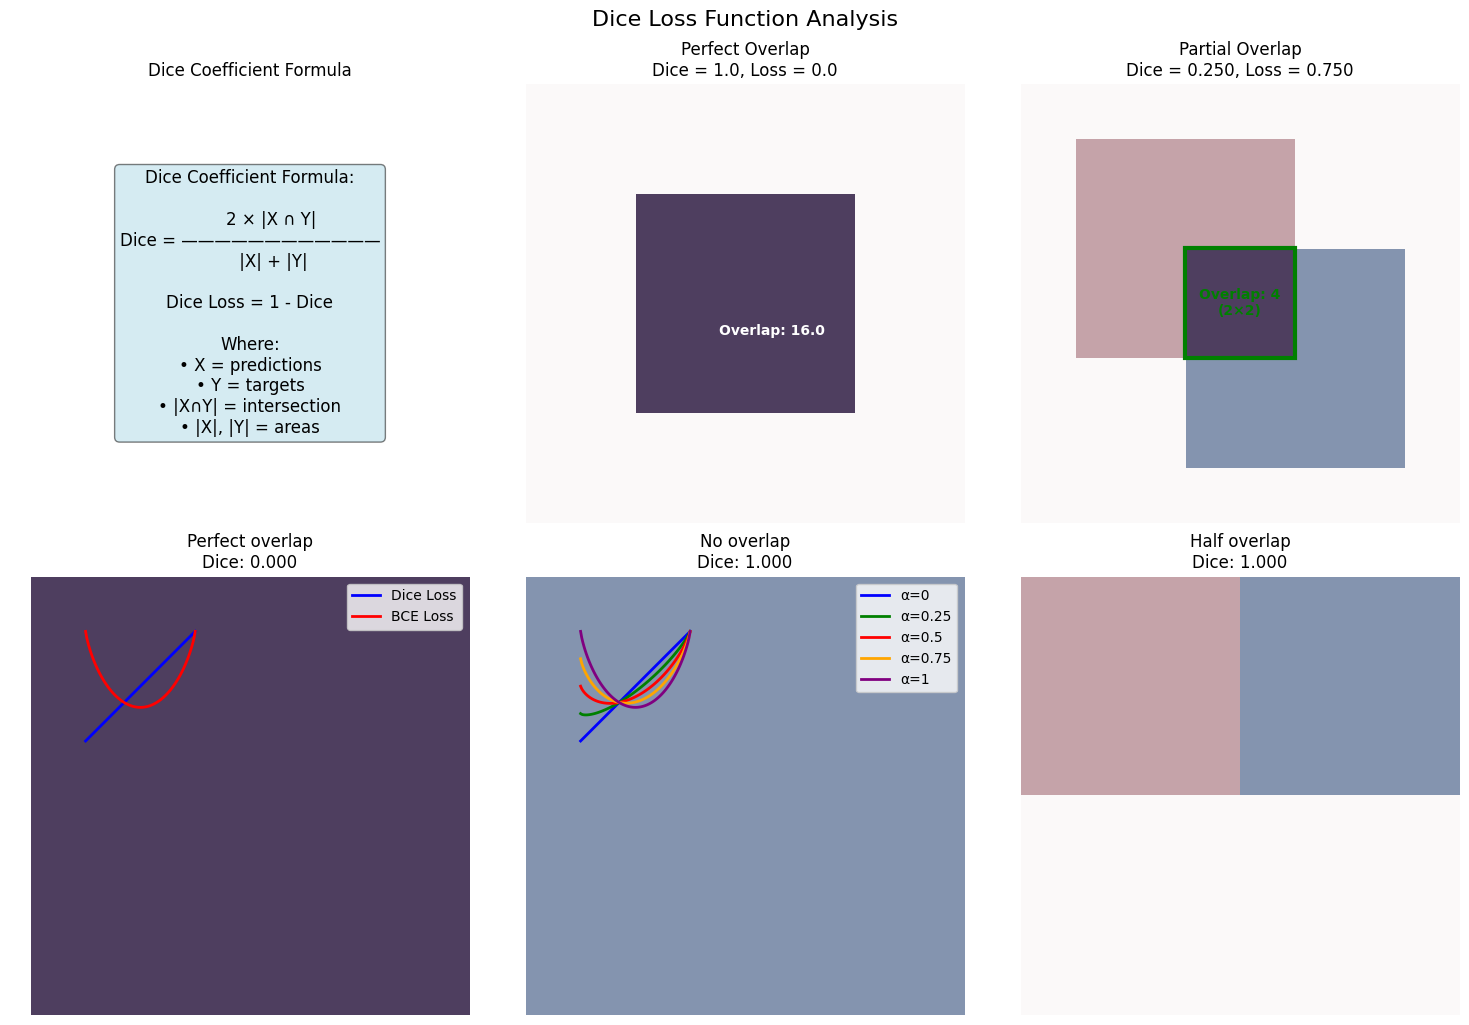


PRACTICAL COMPARISON OF LOSS FUNCTIONS:

Advantages of Dice Loss:
  • Handles class imbalance well (common in medical images)
  • Directly optimizes for overlap (what we care about in segmentation)
  • Less sensitive to extreme class distributions

Advantages of BCE Loss:
  • Well-understood theoretical properties
  • Stable gradients
  • Standard choice for binary classification

Advantages of Combined Loss:
  • Gets benefits of both Dice and BCE
  • Can be tuned with alpha parameter
  • Often works best in practice

When to use which:
  • Dice Loss: Severe class imbalance, small objects
  • BCE Loss: Balanced datasets, general classification
  • Combined: Most segmentation tasks, especially medical imaging

✓ EXERCISE 4 COMPLETED SUCCESSFULLY!


In [26]:
# EXERCISE 4 SOLUTION - Complete and self-contained
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

print("="*60)
print("EXERCISE 4: Custom Dice Loss Function")
print("="*60)

# 1. Implement Dice Loss
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        """
        Dice Loss for segmentation tasks.

        Dice Coefficient = (2 * |X ∩ Y|) / (|X| + |Y|)
        Dice Loss = 1 - Dice Coefficient

        Args:
            smooth: Small constant to avoid division by zero
        """
        super().__init__()
        self.smooth = smooth

    def forward(self, predictions, targets):
        """
        Compute Dice Loss.

        Args:
            predictions: Tensor of shape (N, C, H, W) with probabilities [0, 1]
            targets: Tensor of shape (N, C, H, W) with binary values {0, 1}

        Returns:
            dice_loss: Scalar loss value
        """
        # Flatten predictions and targets
        predictions = predictions.contiguous().view(-1)
        targets = targets.contiguous().view(-1)

        # Calculate intersection and union
        intersection = (predictions * targets).sum()
        union = predictions.sum() + targets.sum()

        # Dice coefficient
        dice = (2. * intersection + self.smooth) / (union + self.smooth)

        # Dice loss
        dice_loss = 1 - dice

        return dice_loss

# 2. Implement Combined Loss (BCE + Dice)
class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5, smooth=1e-6):
        """
        Combined loss: alpha * BCE + (1 - alpha) * Dice

        Args:
            alpha: Weight between BCE and Dice (0.5 = equal weight)
            smooth: Smoothing factor for Dice loss
        """
        super().__init__()
        self.alpha = alpha
        self.bce_loss = nn.BCELoss()
        self.dice_loss = DiceLoss(smooth)

    def forward(self, predictions, targets):
        bce = self.bce_loss(predictions, targets)
        dice = self.dice_loss(predictions, targets)
        combined = self.alpha * bce + (1 - self.alpha) * dice
        return combined, bce.item(), dice.item()

# 3. Test the loss functions
print("Testing Dice Loss with different scenarios...")

# Create test cases
test_cases = [
    ("Perfect overlap", torch.ones(1, 1, 4, 4), torch.ones(1, 1, 4, 4)),
    ("No overlap", torch.zeros(1, 1, 4, 4), torch.ones(1, 1, 4, 4)),
    ("Half overlap", torch.tensor([[[[1, 1, 0, 0], [1, 1, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]]], dtype=torch.float32),
                   torch.tensor([[[[0, 0, 1, 1], [0, 0, 1, 1], [0, 0, 0, 0], [0, 0, 0, 0]]]], dtype=torch.float32)),
    ("Random prediction", torch.rand(1, 1, 4, 4), (torch.rand(1, 1, 4, 4) > 0.5).float()),
]

# Initialize losses
dice_loss_fn = DiceLoss()
bce_loss_fn = nn.BCELoss()
combined_loss_fn = CombinedLoss(alpha=0.5)

# Test each case
print("\n" + "="*60)
print("LOSS CALCULATIONS FOR DIFFERENT SCENARIOS:")
print("="*60)

results = []
for name, pred, target in test_cases:
    dice_loss = dice_loss_fn(pred, target).item()
    bce_loss = bce_loss_fn(pred, target).item()
    combined_loss, bce_part, dice_part = combined_loss_fn(pred, target)

    results.append({
        'name': name,
        'dice': dice_loss,
        'bce': bce_loss,
        'combined': combined_loss.item(),
        'pred': pred,
        'target': target
    })

    print(f"\n{name}:")
    print(f"  Dice Loss:    {dice_loss:.4f}")
    print(f"  BCE Loss:     {bce_loss:.4f}")
    print(f"  Combined Loss: {combined_loss.item():.4f}")
    print(f"    (BCE part: {bce_part:.4f}, Dice part: {dice_part:.4f})")

# 4. Visualize the loss functions
print("\n" + "="*60)
print("VISUALIZING DICE LOSS CONCEPT:")
print("="*60)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Plot 1: Dice coefficient formula
axes[0, 0].text(0.5, 0.5,
                "Dice Coefficient Formula:\n\n"
                "        2 × |X ∩ Y|\n"
                "Dice = ————————————\n"
                "         |X| + |Y|\n\n"
                "Dice Loss = 1 - Dice\n\n"
                "Where:\n"
                "• X = predictions\n"
                "• Y = targets\n"
                "• |X∩Y| = intersection\n"
                "• |X|, |Y| = areas",
                ha='center', va='center', fontsize=12,
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
axes[0, 0].set_title('Dice Coefficient Formula')
axes[0, 0].axis('off')

# Plot 2: Perfect overlap example
perfect_pred = torch.zeros(1, 1, 8, 8)
perfect_target = torch.zeros(1, 1, 8, 8)
perfect_pred[0, 0, 2:6, 2:6] = 1
perfect_target[0, 0, 2:6, 2:6] = 1

axes[0, 1].imshow(perfect_pred[0, 0].numpy(), cmap='Reds', alpha=0.7, vmin=0, vmax=1)
axes[0, 1].imshow(perfect_target[0, 0].numpy(), cmap='Blues', alpha=0.5, vmin=0, vmax=1)
axes[0, 1].set_title('Perfect Overlap\nDice = 1.0, Loss = 0.0')
axes[0, 1].axis('off')

# Add overlap indicator
overlap_area = perfect_pred[0, 0, 2:6, 2:6].sum().item()
axes[0, 1].text(4, 4, f'Overlap: {overlap_area}', ha='center', va='center',
                fontsize=10, fontweight='bold', color='white')

# Plot 3: Partial overlap example
partial_pred = torch.zeros(1, 1, 8, 8)
partial_target = torch.zeros(1, 1, 8, 8)
partial_pred[0, 0, 1:5, 1:5] = 1      # 4x4 square at (1,1)
partial_target[0, 0, 3:7, 3:7] = 1    # 4x4 square at (3,3) - 2x2 overlap

# Calculate intersection
intersection = (partial_pred * partial_target).sum().item()
union = partial_pred.sum().item() + partial_target.sum().item()
dice_coeff = (2 * intersection) / union

axes[0, 2].imshow(partial_pred[0, 0].numpy(), cmap='Reds', alpha=0.7, vmin=0, vmax=1)
axes[0, 2].imshow(partial_target[0, 0].numpy(), cmap='Blues', alpha=0.5, vmin=0, vmax=1)
axes[0, 2].set_title(f'Partial Overlap\nDice = {dice_coeff:.3f}, Loss = {1-dice_coeff:.3f}')
axes[0, 2].axis('off')

# Highlight overlap area
axes[0, 2].add_patch(plt.Rectangle((2.5, 2.5), 2, 2, fill=False, edgecolor='green', linewidth=3))
axes[0, 2].text(3.5, 3.5, f'Overlap: 4\n(2×2)', ha='center', va='center',
                fontsize=10, fontweight='bold', color='green')

# Plot 4: Loss comparison for different overlaps
overlap_ratios = np.linspace(0, 1, 100)
dice_values = (2 * overlap_ratios) / (1 + 1)  # Assuming equal areas
dice_losses = 1 - dice_values
bce_losses = -overlap_ratios * np.log(overlap_ratios + 1e-10) - (1 - overlap_ratios) * np.log(1 - overlap_ratios + 1e-10)

axes[1, 0].plot(overlap_ratios, dice_losses, 'b-', linewidth=2, label='Dice Loss')
axes[1, 0].plot(overlap_ratios, bce_losses, 'r-', linewidth=2, label='BCE Loss')
axes[1, 0].set_xlabel('Overlap Ratio (Intersection/Union)')
axes[1, 0].set_ylabel('Loss Value')
axes[1, 0].set_title('Loss vs Overlap Ratio')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 5: Combined loss with different alpha values
alphas = [0, 0.25, 0.5, 0.75, 1]
colors = ['blue', 'green', 'red', 'orange', 'purple']

for alpha, color in zip(alphas, colors):
    combined_values = alpha * bce_losses + (1 - alpha) * dice_losses
    axes[1, 1].plot(overlap_ratios, combined_values, color=color, linewidth=2,
                   label=f'α={alpha}')

axes[1, 1].set_xlabel('Overlap Ratio')
axes[1, 1].set_ylabel('Loss Value')
axes[1, 1].set_title('Combined Loss with Different α Values')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Plot 6: Test case visualizations
for i, result in enumerate(results[:3]):
    row = 1
    col = i

    pred_img = result['pred'][0, 0].numpy()
    target_img = result['target'][0, 0].numpy()

    axes[row, col].imshow(pred_img, cmap='Reds', alpha=0.7, vmin=0, vmax=1)
    axes[row, col].imshow(target_img, cmap='Blues', alpha=0.5, vmin=0, vmax=1)
    axes[row, col].set_title(f'{result["name"]}\nDice: {result["dice"]:.3f}')
    axes[row, col].axis('off')

plt.tight_layout()
plt.suptitle('Dice Loss Function Analysis', fontsize=16, y=1.02)
plt.show()

# 5. Practical comparison
print("\n" + "="*60)
print("PRACTICAL COMPARISON OF LOSS FUNCTIONS:")
print("="*60)

print("\nAdvantages of Dice Loss:")
print("  • Handles class imbalance well (common in medical images)")
print("  • Directly optimizes for overlap (what we care about in segmentation)")
print("  • Less sensitive to extreme class distributions")

print("\nAdvantages of BCE Loss:")
print("  • Well-understood theoretical properties")
print("  • Stable gradients")
print("  • Standard choice for binary classification")

print("\nAdvantages of Combined Loss:")
print("  • Gets benefits of both Dice and BCE")
print("  • Can be tuned with alpha parameter")
print("  • Often works best in practice")

print("\nWhen to use which:")
print("  • Dice Loss: Severe class imbalance, small objects")
print("  • BCE Loss: Balanced datasets, general classification")
print("  • Combined: Most segmentation tasks, especially medical imaging")

print("\n" + "="*60)
print("✓ EXERCISE 4 COMPLETED SUCCESSFULLY!")
print("="*60)

## Exercise 5: Train CNN and Plot Loss Curve

EXERCISE 5: Train CNN and Plot Loss Curves
Setting up for training...

Test batch shapes:
  Images shape: torch.Size([8, 1, 64, 64])  (Expected: [8, 1, 64, 64])
  Labels shape: torch.Size([8, 1])  (Expected: [8, 1])
  Model output shape: torch.Size([8, 1])  (Expected: [8, 1])
✓ Shapes are compatible!

Dataset created with 100 samples
Batch size: 8, Total batches per epoch: 13

TRAINING DIFFERENT CONFIGURATIONS

1. Training SimpleCNN with BCE Loss:
Training with BCE Loss...
----------------------------------------
  Epoch 1, Batch  0: Loss = 0.6945
  Epoch 1, Batch  5: Loss = 0.6713
  Epoch 1, Batch 10: Loss = 0.9541
Epoch 1/5 completed.
  Average Loss: 0.7144
----------------------------------------
  Epoch 2, Batch  0: Loss = 0.6778
  Epoch 2, Batch  5: Loss = 0.6927
  Epoch 2, Batch 10: Loss = 0.7200
Epoch 2/5 completed.
  Average Loss: 0.6990
----------------------------------------
  Epoch 3, Batch  0: Loss = 0.7056
  Epoch 3, Batch  5: Loss = 0.6822
  Epoch 3, Batch 10: Loss = 0.7

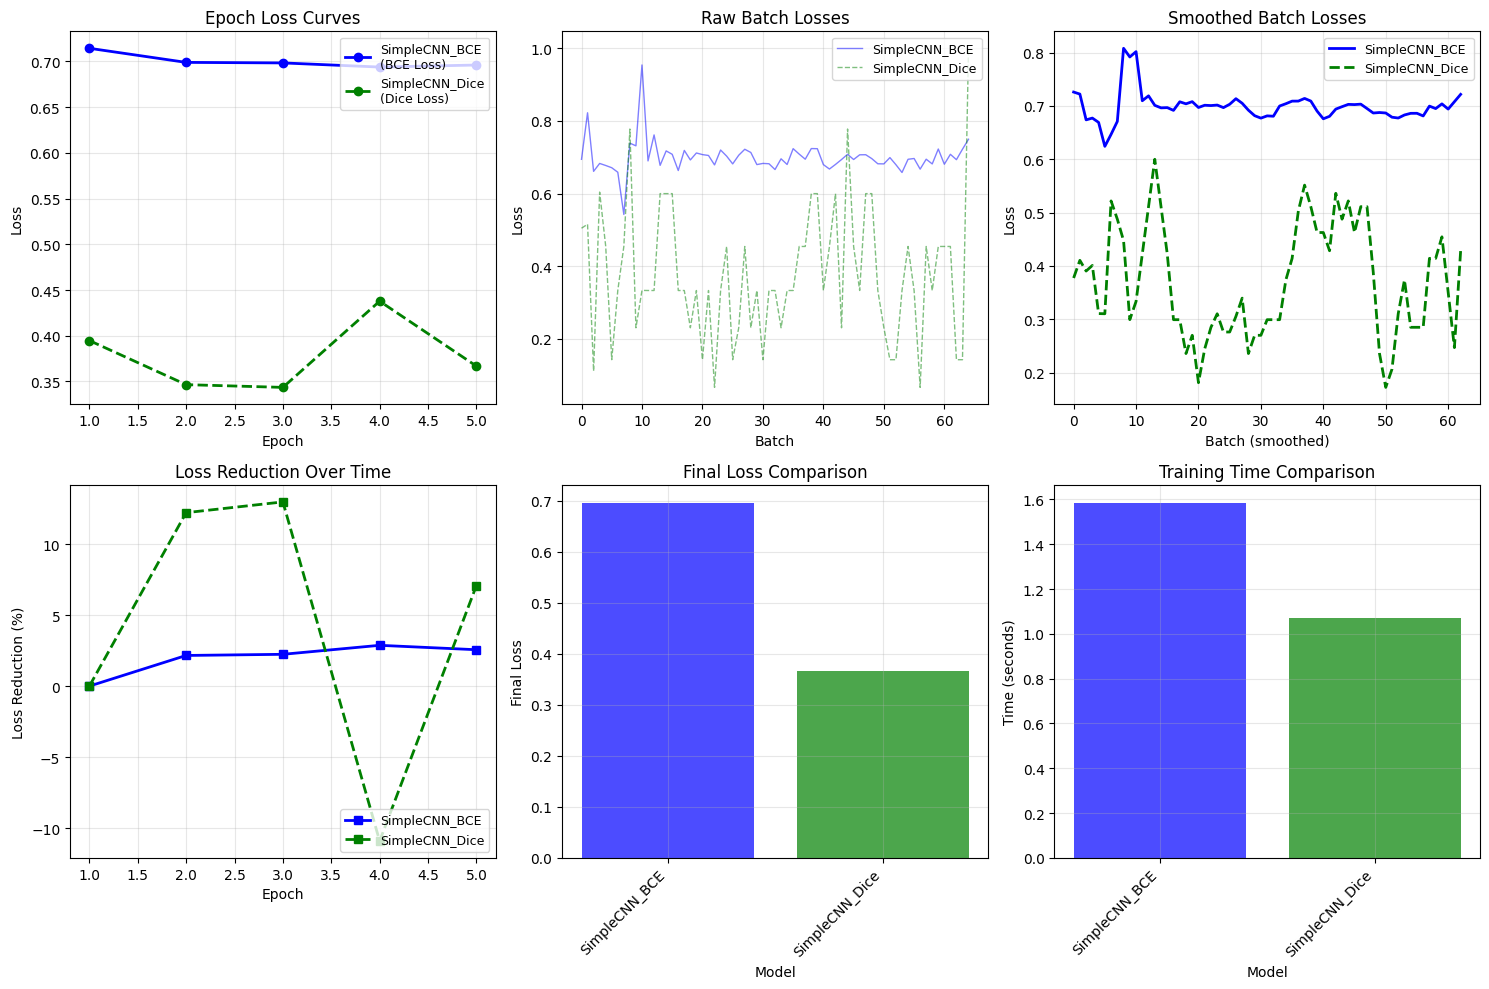


TRAINING SUMMARY

SimpleCNN_BCE:
  Loss function: BCE Loss
  Initial loss:  0.7144
  Final loss:    0.6961
  Improvement:   2.6%
  Epoch losses:  ['0.7144', '0.6990', '0.6984', '0.6939', '0.6961']
  Training time: 1.6 seconds

SimpleCNN_Dice:
  Loss function: Dice Loss
  Initial loss:  0.3947
  Final loss:    0.3668
  Improvement:   7.1%
  Epoch losses:  ['0.3947', '0.3465', '0.3435', '0.4378', '0.3668']
  Training time: 1.1 seconds

PREDICTION VISUALIZATION


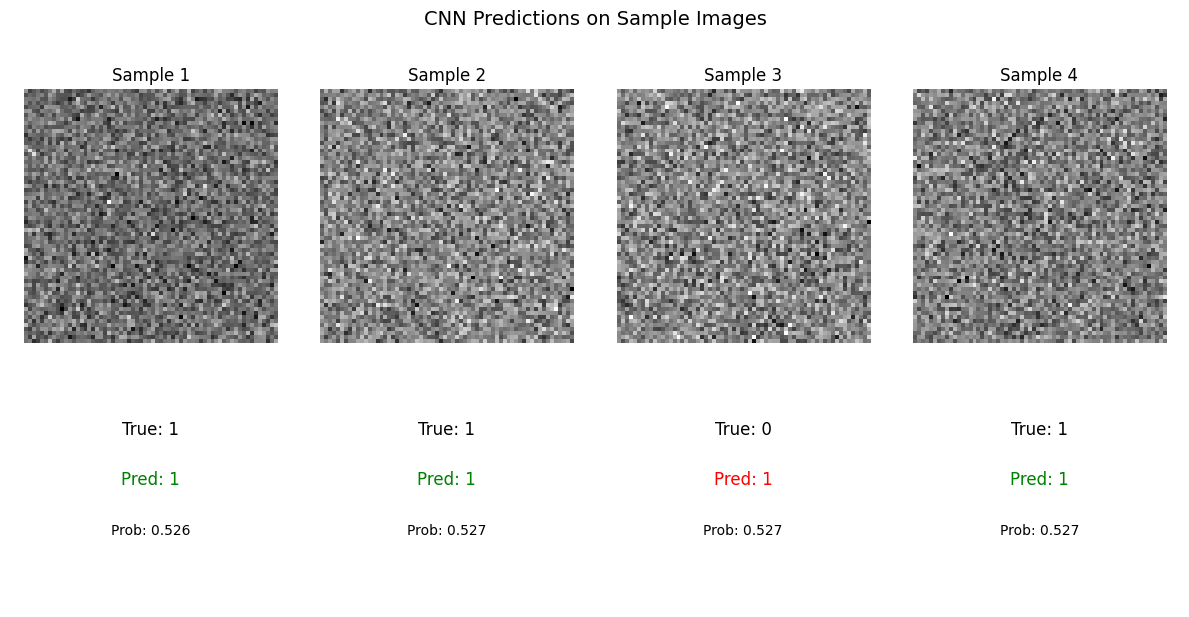


✓ EXERCISE 5 COMPLETED SUCCESSFULLY!


In [28]:
# EXERCISE 5 SOLUTION - FIXED VERSION
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import time

print("="*60)
print("EXERCISE 5: Train CNN and Plot Loss Curves")
print("="*60)

# ============================================
# 1. FIXED DATASET - For binary classification
# ============================================
class BinaryClassificationDataset(Dataset):
    def __init__(self, num_samples=200):
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Generate random image
        image = torch.randn(1, 64, 64) * 0.5 + 0.5

        # Generate binary label (0 or 1) - NOT a full mask!
        # For binary classification, we need a single label, not a mask
        label = torch.tensor([1.0] if torch.rand(1) > 0.5 else [0.0])

        return image, label

# ============================================
# 2. SIMPLE CNN FOR BINARY CLASSIFICATION
# ============================================
class SimpleCNN64(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),  # (16, 64, 64)
            nn.ReLU(),
            nn.MaxPool2d(2),                  # (16, 32, 32)
            nn.Conv2d(16, 32, 3, padding=1),  # (32, 32, 32)
            nn.ReLU(),
            nn.MaxPool2d(2),                  # (32, 16, 16)
        )
        # Flatten: 32 * 16 * 16 = 8192
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 16 * 16, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()  # Output probability between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.classifier(x)
        return x

# ============================================
# 3. MODIFIED DICE LOSS FOR BINARY CLASSIFICATION
# ============================================
class BinaryDiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth

    def forward(self, predictions, targets):
        """
        Modified Dice Loss for binary classification
        predictions: (batch, 1) probabilities
        targets: (batch, 1) binary labels
        """
        predictions = predictions.squeeze()
        targets = targets.squeeze()

        intersection = (predictions * targets).sum()
        union = predictions.sum() + targets.sum()

        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice

# ============================================
# 4. FIXED TRAINING FUNCTION
# ============================================
def train_cnn_simple(model, dataloader, num_epochs=5, use_dice_loss=False):
    """
    Fixed training function for binary classification
    """
    # Setup
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    if use_dice_loss:
        criterion = BinaryDiceLoss()
        loss_name = "Dice Loss"
    else:
        criterion = nn.BCELoss()
        loss_name = "BCE Loss"

    # Track losses
    epoch_losses = []
    batch_losses = []

    # Training loop
    model.train()
    start_time = time.time()

    print(f"Training with {loss_name}...")
    print("-" * 40)

    for epoch in range(num_epochs):
        epoch_loss = 0
        num_batches = 0

        for batch_idx, (images, labels) in enumerate(dataloader):
            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            predictions = model(images)

            # Debug shapes (uncomment if needed)
            # print(f"Predictions shape: {predictions.shape}, Labels shape: {labels.shape}")

            # Ensure labels have correct shape (batch_size, 1)
            if len(labels.shape) == 1:
                labels = labels.unsqueeze(1)

            # Compute loss
            loss = criterion(predictions, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Track losses
            loss_value = loss.item()
            epoch_loss += loss_value
            batch_losses.append(loss_value)
            num_batches += 1

            # Print progress
            if batch_idx % 5 == 0:  # Changed to 5 since we have fewer batches
                print(f"  Epoch {epoch+1}, Batch {batch_idx:2d}: Loss = {loss_value:.4f}")

        # Calculate average epoch loss
        avg_epoch_loss = epoch_loss / num_batches
        epoch_losses.append(avg_epoch_loss)

        print(f"Epoch {epoch+1}/{num_epochs} completed.")
        print(f"  Average Loss: {avg_epoch_loss:.4f}")
        print("-" * 40)

    training_time = time.time() - start_time

    return {
        'epoch_losses': epoch_losses,
        'batch_losses': batch_losses,
        'training_time': training_time,
        'loss_name': loss_name
    }

# ============================================
# 5. PLOTTING FUNCTION (UNCHANGED)
# ============================================
def plot_training_results(results_dict):
    """
    Plot training results from multiple models
    """
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    colors = ['blue', 'green', 'red', 'orange']
    line_styles = ['-', '--', '-.', ':']

    for idx, (model_name, results) in enumerate(results_dict.items()):
        color = colors[idx % len(colors)]
        style = line_styles[idx % len(line_styles)]

        # Plot 1: Epoch losses
        axes[0, 0].plot(
            range(1, len(results['epoch_losses']) + 1),
            results['epoch_losses'],
            label=f"{model_name}\n({results['loss_name']})",
            color=color,
            linestyle=style,
            linewidth=2,
            marker='o'
        )

        # Plot 2: Batch losses (raw)
        axes[0, 1].plot(
            results['batch_losses'],
            label=model_name,
            color=color,
            linestyle=style,
            alpha=0.5,
            linewidth=1
        )

        # Plot 3: Batch losses (smoothed)
        batch_losses = results['batch_losses']
        if len(batch_losses) > 10:
            window_size = max(1, len(batch_losses) // 20)
            smoothed = np.convolve(batch_losses, np.ones(window_size)/window_size, mode='valid')
            axes[0, 2].plot(
                smoothed,
                label=model_name,
                color=color,
                linestyle=style,
                linewidth=2
            )

        # Plot 4: Loss reduction over epochs
        if len(results['epoch_losses']) > 1:
            reduction = [(results['epoch_losses'][0] - loss) / results['epoch_losses'][0] * 100
                        for loss in results['epoch_losses']]
            axes[1, 0].plot(
                range(1, len(reduction) + 1),
                reduction,
                label=model_name,
                color=color,
                linestyle=style,
                linewidth=2,
                marker='s'
            )

        # Plot 5: Final loss comparison (bar chart)
        axes[1, 1].bar(
            idx,
            results['epoch_losses'][-1],
            label=model_name,
            color=color,
            alpha=0.7
        )

        # Plot 6: Training time comparison
        axes[1, 2].bar(
            idx,
            results['training_time'],
            label=model_name,
            color=color,
            alpha=0.7
        )

    # Configure subplots
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Epoch Loss Curves')
    axes[0, 0].legend(fontsize=9, loc='upper right')
    axes[0, 0].grid(True, alpha=0.3)

    axes[0, 1].set_xlabel('Batch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].set_title('Raw Batch Losses')
    axes[0, 1].legend(fontsize=9, loc='upper right')
    axes[0, 1].grid(True, alpha=0.3)

    axes[0, 2].set_xlabel('Batch (smoothed)')
    axes[0, 2].set_ylabel('Loss')
    axes[0, 2].set_title('Smoothed Batch Losses')
    axes[0, 2].legend(fontsize=9, loc='upper right')
    axes[0, 2].grid(True, alpha=0.3)

    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss Reduction (%)')
    axes[1, 0].set_title('Loss Reduction Over Time')
    axes[1, 0].legend(fontsize=9, loc='lower right')
    axes[1, 0].grid(True, alpha=0.3)

    axes[1, 1].set_xlabel('Model')
    axes[1, 1].set_ylabel('Final Loss')
    axes[1, 1].set_title('Final Loss Comparison')
    axes[1, 1].set_xticks(range(len(results_dict)))
    axes[1, 1].set_xticklabels(results_dict.keys(), rotation=45, ha='right')
    axes[1, 1].grid(True, alpha=0.3)

    axes[1, 2].set_xlabel('Model')
    axes[1, 2].set_ylabel('Time (seconds)')
    axes[1, 2].set_title('Training Time Comparison')
    axes[1, 2].set_xticks(range(len(results_dict)))
    axes[1, 2].set_xticklabels(results_dict.keys(), rotation=45, ha='right')
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# ============================================
# 6. MAIN EXECUTION - FIXED
# ============================================
print("Setting up for training...")

# Create dataset and dataloader for BINARY CLASSIFICATION
dataset = BinaryClassificationDataset(num_samples=100)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# Test one batch to verify shapes
test_batch = next(iter(dataloader))
test_images, test_labels = test_batch
print(f"\nTest batch shapes:")
print(f"  Images shape: {test_images.shape}  (Expected: [8, 1, 64, 64])")
print(f"  Labels shape: {test_labels.shape}  (Expected: [8, 1])")

# Test model output shape
test_model = SimpleCNN64()
with torch.no_grad():
    test_output = test_model(test_images)
print(f"  Model output shape: {test_output.shape}  (Expected: [8, 1])")
print("✓ Shapes are compatible!")

print(f"\nDataset created with {len(dataset)} samples")
print(f"Batch size: 8, Total batches per epoch: {len(dataloader)}")

# ============================================
# 7. TRAIN DIFFERENT CONFIGURATIONS
# ============================================
print("\n" + "="*60)
print("TRAINING DIFFERENT CONFIGURATIONS")
print("="*60)

results = {}

# Configuration 1: SimpleCNN with BCE Loss
print("\n1. Training SimpleCNN with BCE Loss:")
model1 = SimpleCNN64()
results['SimpleCNN_BCE'] = train_cnn_simple(
    model=model1,
    dataloader=dataloader,
    num_epochs=5,
    use_dice_loss=False
)

# Configuration 2: SimpleCNN with Dice Loss
print("\n2. Training SimpleCNN with Dice Loss:")
model2 = SimpleCNN64()
results['SimpleCNN_Dice'] = train_cnn_simple(
    model=model2,
    dataloader=dataloader,
    num_epochs=5,
    use_dice_loss=True
)

# Configuration 3: Test model accuracy
print("\n3. Testing model accuracy on training data...")
model1.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in dataloader:
        predictions = model1(images)
        # Convert probabilities to binary predictions
        binary_preds = (predictions > 0.5).float()
        correct += (binary_preds == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total * 100
print(f"  Model accuracy on training data: {accuracy:.1f}%")
print(f"  Correct: {correct}/{total}")

# ============================================
# 8. PLOT RESULTS
# ============================================
print("\n" + "="*60)
print("GENERATING LOSS PLOTS")
print("="*60)
plot_training_results(results)

# ============================================
# 9. PRINT SUMMARY
# ============================================
print("\n" + "="*60)
print("TRAINING SUMMARY")
print("="*60)

for model_name, result in results.items():
    if result['epoch_losses']:
        initial_loss = result['epoch_losses'][0]
        final_loss = result['epoch_losses'][-1]
        improvement = ((initial_loss - final_loss) / initial_loss * 100) if initial_loss > 0 else 0

        print(f"\n{model_name}:")
        print(f"  Loss function: {result['loss_name']}")
        print(f"  Initial loss:  {initial_loss:.4f}")
        print(f"  Final loss:    {final_loss:.4f}")
        print(f"  Improvement:   {improvement:.1f}%")
        print(f"  Epoch losses:  {[f'{x:.4f}' for x in result['epoch_losses']]}")
        print(f"  Training time: {result['training_time']:.1f} seconds")

# ============================================
# 10. BONUS: PREDICTION VISUALIZATION
# ============================================
print("\n" + "="*60)
print("PREDICTION VISUALIZATION")
print("="*60)

# Get some samples and make predictions
model1.eval()
with torch.no_grad():
    sample_images, sample_labels = next(iter(dataloader))
    predictions = model1(sample_images[:4])  # First 4 samples
    probabilities = predictions.numpy()
    binary_predictions = (predictions > 0.5).float().numpy()

# Visualize
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

for i in range(4):
    # Plot image
    axes[0, i].imshow(sample_images[i].squeeze(), cmap='gray')
    axes[0, i].set_title(f'Sample {i+1}')
    axes[0, i].axis('off')

    # Plot prediction info
    true_label = sample_labels[i].item()
    pred_prob = probabilities[i][0]
    pred_class = binary_predictions[i][0]

    color = 'green' if pred_class == true_label else 'red'

    axes[1, i].text(0.5, 0.7, f'True: {int(true_label)}',
                   ha='center', va='center', fontsize=12)
    axes[1, i].text(0.5, 0.5, f'Pred: {int(pred_class)}',
                   ha='center', va='center', fontsize=12, color=color)
    axes[1, i].text(0.5, 0.3, f'Prob: {pred_prob:.3f}',
                   ha='center', va='center', fontsize=10)
    axes[1, i].axis('off')
    axes[1, i].set_facecolor('lightgray')

plt.suptitle('CNN Predictions on Sample Images', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("✓ EXERCISE 5 COMPLETED SUCCESSFULLY!")
print("="*60)